### Importing Necessary Imports

In [ ]:
import os
import random
import shutil
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from  IPython import display

plt.rcParams['figure.figsize'] = (12, 8)
print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
GPU is NOT AVAILABLE


### Connecting to Collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Path Setup

In [ ]:
PATH = '/content'
DATA_PATH = '/content/drive/MyDrive/Datasets/complete_dsm_aug'

In [ ]:
def get_dataset_size(path):
    num_of_images = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        num_images_in_folder = len(os.listdir(folder_path))
        num_of_images[folder] = num_images_in_folder
    return num_of_images

In [ ]:
new_dataset_size = get_dataset_size(DATA_PATH)
print('New Dataset Size:', new_dataset_size)

New Dataset Size: {'non_cancer': 3950, 'cancer': 4772}


In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.chdir(PATH)
    IMAGES_PATH = PATH +'/images'

    if os.path.isdir(IMAGES_PATH) is False:
        os.mkdir('images')
        IMAGES_PATH = PATH + '/images'
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)

    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [ ]:
def plot_images(path, num_images=16, figsize=(8, 8), save_id=None):
    images = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            images.append((image_path, folder))

    plt.figure(figsize=figsize)
    for i in range(num_images):
        random_img = random.choice(images)
        img = plt.imread(random_img[0])
        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        plt.title(random_img[1])
        plt.imshow(img)

    plt.tight_layout()

    if save_id is not None:
        save_fig(save_id)
    plt.show()


Saving figure images_dd


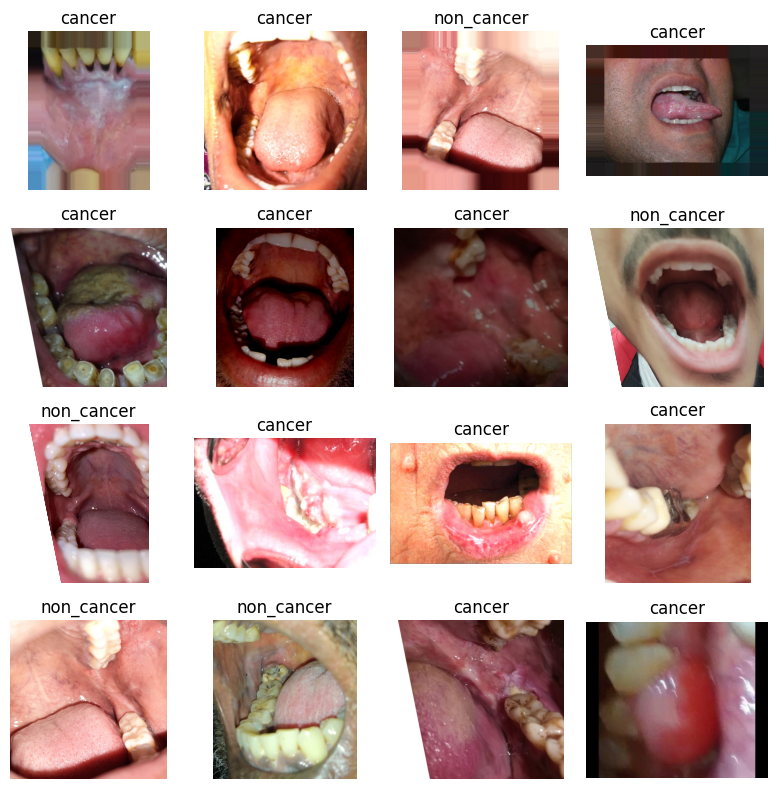

In [ ]:
plot_images(DATA_PATH, save_id='images_dd')

In [ ]:
def train_val_test_split(root_dir, classes_dir,new_dir, val_ratio=0.25, test_ratio=0.15):
    os.mkdir(new_dir)
    os.chdir(new_dir)

    for cls in classes_dir:

        os.makedirs('train/' + cls, exist_ok=True)
        os.makedirs('val/' + cls, exist_ok=True)
        os.makedirs('test/' + cls, exist_ok=True)

        src = os.path.join(root_dir, cls)
        all_file_names = os.listdir(src)
        np.random.shuffle(all_file_names)

        num_images = len(all_file_names)
        num_val = int(num_images * val_ratio)
        num_test = int(num_images * test_ratio)
        num_train = num_images - num_val - num_test

        train_file_names = all_file_names[:num_train]
        val_file_names = all_file_names[num_train:num_train + num_val]
        test_file_names = all_file_names[num_train + num_val:]

        print(f"{cls.upper()}:")
        print('Total images: ', num_images)
        print('Training: ', len(train_file_names))
        print('Validation: ', len(val_file_names))
        print('Testing: ', len(test_file_names))


        for name in train_file_names:
            shutil.copy(os.path.join(src, name), os.path.join('train', cls))

        for name in val_file_names:
            shutil.copy(os.path.join(src, name), os.path.join('val', cls))

        for name in test_file_names:
            shutil.copy(os.path.join(src, name), os.path.join('test', cls))
        print()


In [ ]:
root_dir = DATA_PATH
new_dir = PATH + '/splitted'
classes_dir = ['cancer', 'non_cancer']
train_val_test_split(root_dir, classes_dir ,new_dir)

CANCER:
Total images:  4772
Training:  2864
Validation:  1193
Testing:  715

NON_CANCER:
Total images:  3950
Training:  2371
Validation:  987
Testing:  592



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape=(512, 512, 3)):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())


    model.add(Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())


    model.add(Dropout(rate=0.25))
    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                        

In [ ]:
from math import ceil
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

def image_data_generator(data_dir, zoom_range=0.2, shear_range=0.2, horizontal_flip=True, class_weights=None):

    datagen = image.ImageDataGenerator(
        rescale=1./255,
    )

    return datagen.flow_from_directory(
        directory=data_dir,
        target_size=(512,512),
        batch_size=16,
        class_mode='binary',
        shuffle = True
    )

def train_model_with_data_generators(model, train_dir, val_dir, epochs=32,class_weight=None):

    train_data = image_data_generator(train_dir)
    val_data = image_data_generator(val_dir)

    print("Train Data:")
    print("Found", train_data.samples, "images belonging to", len(train_data.class_indices), "classes.")
    print("Class Indices:", train_data.class_indices)
    print()

    print("Validation Data:")
    print("Found", val_data.samples, "images belonging to", len(val_data.class_indices), "classes.")
    print()

    # mc = ModelCheckpoint(
    #     filepath="cnn_model.keras",
    #     monitor='val_accuracy',
    #     verbose=1,
    #     save_best_only=True,
    #     mode='auto'
    # )
    es = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # rp = ReduceLROnPlateau(
    #     monitor='val_accuracy',
    #     verbose=1,
    #     mode='max',
    #     factor=0.1,
    #     min_lr=1e-8,
    #     patience=5
    #     )
    callbacks = [es]


    steps_per_epoch = ceil(train_data.samples / train_data.batch_size)
    validation_steps = ceil(val_data.samples / val_data.batch_size)

    # Fitting the Model
    history = model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_data,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weight
    )

    return history

In [ ]:
train_dir = "/content/splitted/train"
val_dir = "/content/splitted/val"
training_history = train_model_with_data_generators(cnn_model, train_dir, val_dir,32)

Found 5235 images belonging to 2 classes.
Found 2180 images belonging to 2 classes.
Train Data:
Found 5235 images belonging to 2 classes.
Class Indices: {'cancer': 0, 'non_cancer': 1}

Validation Data:
Found 2180 images belonging to 2 classes.

Epoch 1/32
328/328 [==============================] - 166s 465ms/step - loss: 1.3992 - accuracy: 0.5666 - val_loss: 17.2064 - val_accuracy: 0.5550
Epoch 2/32
328/328 [==============================] - 145s 442ms/step - loss: 0.6447 - accuracy: 0.6287 - val_loss: 0.6746 - val_accuracy: 0.5463
Epoch 3/32
328/328 [==============================] - 150s 457ms/step - loss: 0.6349 - accuracy: 0.6483 - val_loss: 0.6437 - val_accuracy: 0.6349
Epoch 4/32
328/328 [==============================] - 142s 432ms/step - loss: 0.6247 - accuracy: 0.6485 - val_loss: 14.3265 - val_accuracy: 0.5197
Epoch 5/32
328/328 [==============================] - 146s 444ms/step - loss: 0.6531 - accuracy: 0.5947 - val_loss: 0.6610 - val_accuracy: 0.6436
Epoch 6/32
328/328 [===

In [ ]:
def plot_training(history, name):
    hist = pd.DataFrame()
    hist["Train Loss"] = history.history['loss']
    hist["Validation Loss"] = history.history['val_loss']
    hist["Train Accuracy"] = history.history['accuracy']
    hist["Validation Accuracy"] = history.history['val_accuracy']

    fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    hist[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    hist[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1])
    save_fig(name)
    plt.show()

Saving figure cnn_train_plot


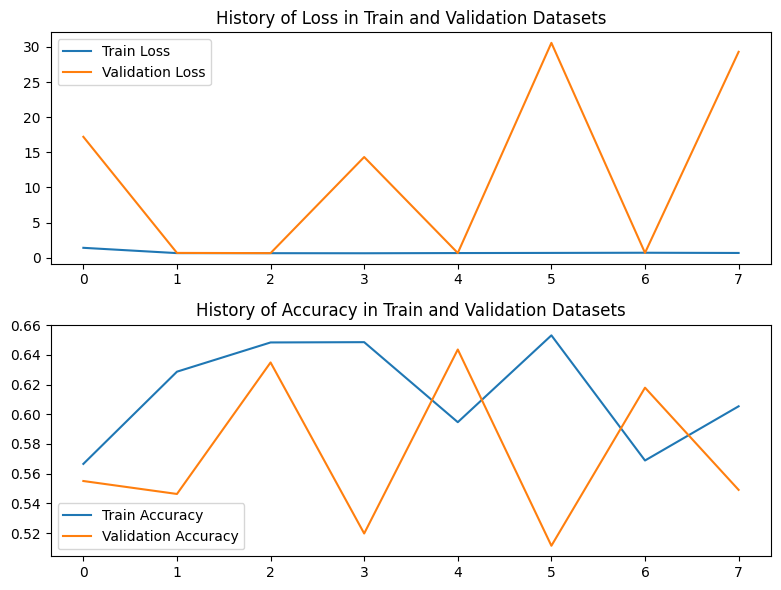

In [ ]:
plot_training(training_history,'cnn_train_plot')

In [ ]:
def test_data_generator(data_dir, zoom_range=0.2, shear_range=0.2, horizontal_flip=True):

    datagen = image.ImageDataGenerator(
        rescale=1./255,
    )

    return datagen.flow_from_directory(
        directory=data_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary',
        shuffle=False,
        # class_weights=class_weights
    )

In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image

def plot_confusion(y_true, y_pred, name, labels):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    save_fig(name)
    plt.show()


In [ ]:
def test_model(model, test_data, BATCH_SIZE, labels):

    predictions = model.predict(test_data)
    y_pred = np.round(predictions).reshape(-1)
    y_true = test_data.classes

    plot_confusion(y_true, y_pred, 'confusion_matrix', labels)

    test_loss, test_acc = model.evaluate(test_data, batch_size=BATCH_SIZE)

    return test_loss, test_acc

Found 1307 images belonging to 2 classes.
41/41 [==============================] - 37s 814ms/step
Saving figure confusion_matrix


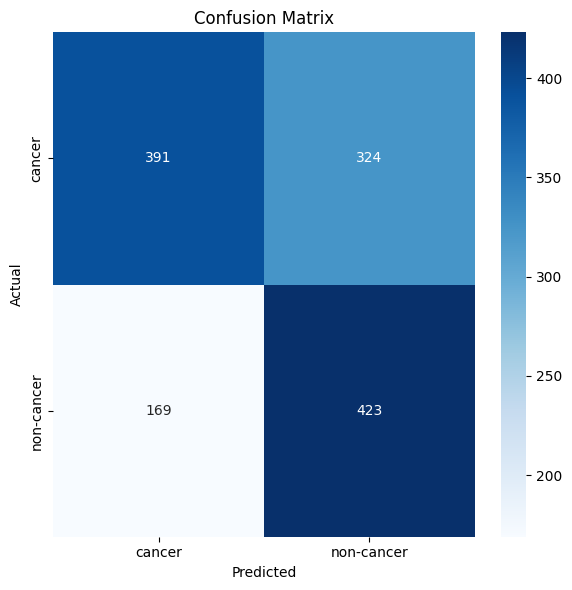

41/41 [==============================] - 33s 802ms/step - loss: 0.6478 - accuracy: 0.6228
Test Loss: 0.6477912068367004
Test Accuracy: 0.6228002905845642


In [ ]:
test_dir = "splitted/test"
BATCH_SIZE = 32
labels = ['cancer', 'non-cancer']

test_data = test_data_generator(test_dir)

test_loss, test_acc = test_model(cnn_model, test_data, BATCH_SIZE, labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def print_precision_recall_f1(history, model):

    true_labels = test_data.classes
    predictions = model.predict(test_data)
    predicted_labels = np.round(predictions).reshape(-1)

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [ ]:
print_precision_recall_f1(training_history, cnn_model)

41/41 [==============================] - 25s 613ms/step
Precision: 0.5662650602409639
Recall: 0.714527027027027
F1 Score: 0.6318147871545929


In [ ]:
from tensorflow.keras.applications import VGG19

In [ ]:
base = VGG19(weights='imagenet', include_top=False, input_shape=(512,512,3))
base.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                              

In [ ]:
from tensorflow.keras.applications import VGG19

def create_vgg19_model(weights,input_shape, num_classes):

    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'],)

    return model

In [ ]:
vgg19_model = create_vgg19_model((512,512,3),2)
vgg19_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 512)               67109376  
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 87134273 (332.39 MB)
Trainable params: 87134273 (332.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
training_history2 = train_model_with_data_generators(vgg19_model, train_dir, val_dir, epochs=32)

Found 5235 images belonging to 2 classes.
Found 2180 images belonging to 2 classes.
Train Data:
Found 5235 images belonging to 2 classes.
Class Indices: {'cancer': 0, 'non_cancer': 1}

Validation Data:
Found 2180 images belonging to 2 classes.

Epoch 1/32
328/328 [==============================] - 511s 1s/step - loss: 45.4171 - accuracy: 0.5349 - val_loss: 0.6897 - val_accuracy: 0.5472
Epoch 2/32
328/328 [==============================] - 415s 1s/step - loss: 0.6891 - accuracy: 0.5471 - val_loss: 0.6887 - val_accuracy: 0.5472
Epoch 3/32
328/328 [==============================] - 448s 1s/step - loss: 0.6888 - accuracy: 0.5471 - val_loss: 0.6887 - val_accuracy: 0.5472
Epoch 4/32
328/328 [==============================] - 415s 1s/step - loss: 0.6888 - accuracy: 0.5471 - val_loss: 0.6887 - val_accuracy: 0.5472
Epoch 5/32
328/328 [==============================] - 413s 1s/step - loss: 0.6888 - accuracy: 0.5471 - val_loss: 0.6887 - val_accuracy: 0.5472
Epoch 6/32
328/328 [===================

Saving figure vgg19_train_plot


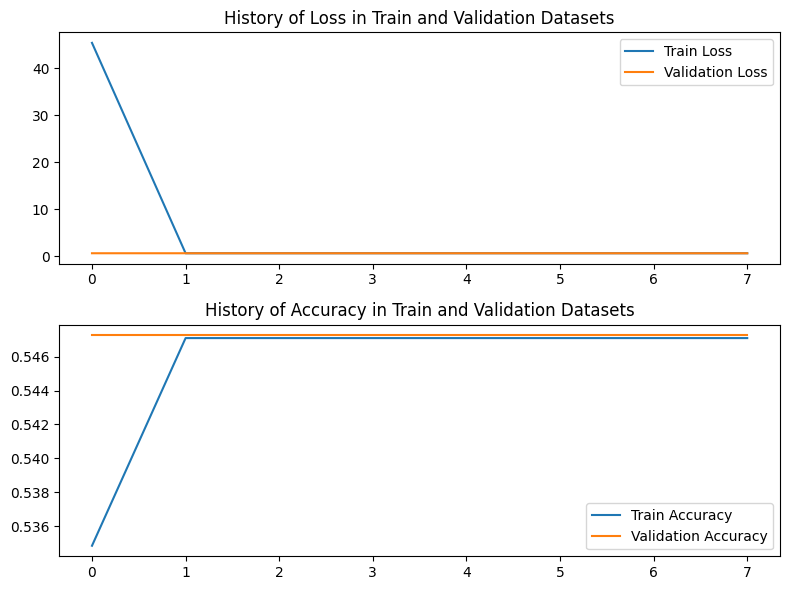

In [ ]:
plot_training(training_history2,'vgg19_train_plot')

Found 1307 images belonging to 2 classes.
41/41 [==============================] - 81s 1s/step
Saving figure confusion_matrix


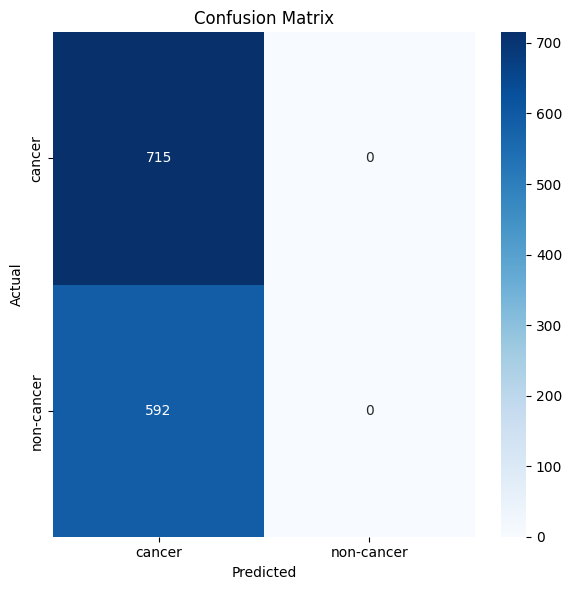

41/41 [==============================] - 33s 808ms/step - loss: 0.6887 - accuracy: 0.5471
Test Loss: 0.6887127757072449
Test Accuracy: 0.5470543503761292


In [ ]:
test_dir = "splitted/test"
BATCH_SIZE = 32
labels = ['cancer', 'non-cancer']

test_data = test_data_generator(test_dir)

test_loss, test_acc = test_model(vgg19_model, test_data, BATCH_SIZE, labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
print_precision_recall_f1(training_history2, vgg19_model)

41/41 [==============================] - 43s 1s/step
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
vgg19_model2 = create_vgg19_model(None,(512,512,3),2)
vgg19_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 87134273 (332.39 MB)
Trainable params: 87134273 (332.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_dir = "/content/splitted/train"
val_dir = "/content/splitted/val"

In [ ]:
training_history3 = train_model_with_data_generators(vgg19_model2, train_dir, val_dir, epochs=32)

Found 5235 images belonging to 2 classes.
Found 2180 images belonging to 2 classes.
Train Data:
Found 5235 images belonging to 2 classes.
Class Indices: {'cancer': 0, 'non_cancer': 1}

Validation Data:
Found 2180 images belonging to 2 classes.

Epoch 1/32
 18/328 [>.............................] - ETA: 16:30:55 - loss: 436.5121 - accuracy: 0.5035

In [ ]:
plot_training(training_history3,'vgg19_train_plot2')

In [ ]:
test_dir = "splitted/test"
BATCH_SIZE = 32
labels = ['cancer', 'non-cancer']

test_data = test_data_generator(test_dir)

test_loss, test_acc = test_model(vgg19_model2, test_data, BATCH_SIZE, labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
print_precision_recall_f1(training_history3, vgg19_model2)